In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\User\anaconda3\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot:xlabel='target', ylabel='count'>

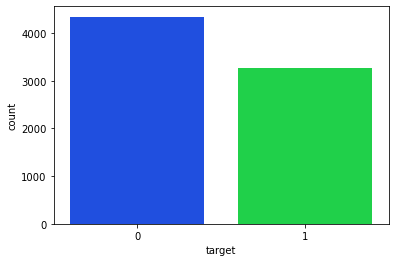

In [4]:
target = train_df['target']
sns.countplot(target)

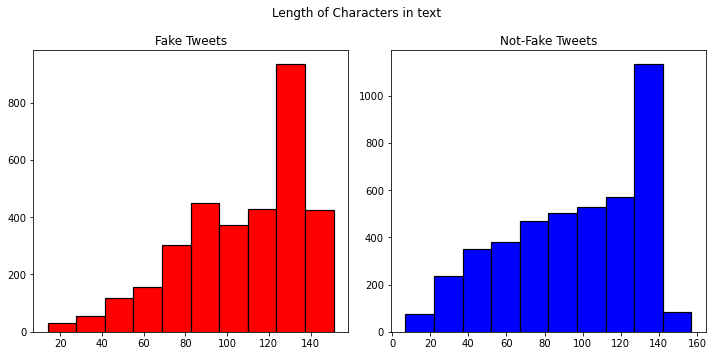

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = train_df[train_df['target']==1]['text'].str.len()
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Fake Tweets')
char_len_ndis = train_df[train_df['target']==0]['text'].str.len()
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Not-Fake Tweets')
plt.suptitle("Length of Characters in text")
plt.tight_layout()
plt.show()

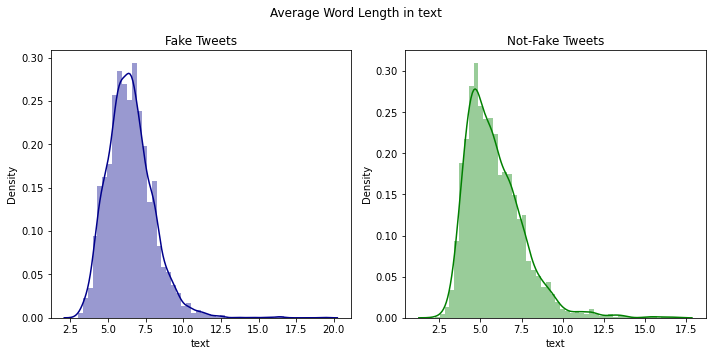

In [6]:
# Analysing average word length in text.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis =train_df[train_df['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Fake Tweets')
char_len_ndis = train_df[train_df['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not-Fake Tweets')
plt.suptitle("Average Word Length in text")
plt.tight_layout()
plt.show()

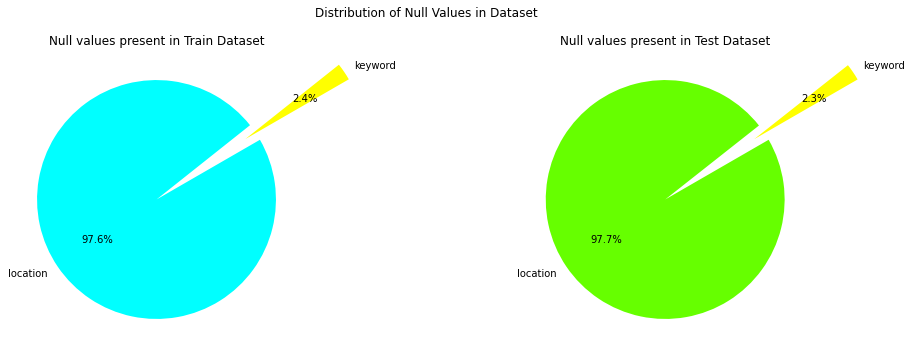

In [7]:
# Checking Null values
missing_train = train_df.isnull().sum()  
missing_test = test_df.isnull().sum()  
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
missing_train = missing_train[missing_train>0].sort_values()
ax1.pie(missing_train,autopct='%1.1f%%',startangle=30,explode=[0.9,0],labels=["keyword","location"],colors=['yellow','cyan'])
ax1.set_title("Null values present in Train Dataset")

missing_test = missing_test[missing_test>0].sort_values()
ax2.pie(missing_test,autopct='%1.1f%%',startangle=30,explode=[0.9,0],labels=["keyword","location"],colors=['yellow','#66ff00'])
ax2.set_title("Null values present in Test Dataset")
plt.suptitle("Distribution of Null Values in Dataset")
plt.tight_layout()
plt.show()


In [8]:
# Seperating independent and dependent features
X = train_df.drop(columns=["target"],axis=1)
y = train_df["target"]

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Perfoming data cleaning

messages_train = X.copy()
messages_test  = test_df.copy()

ps = PorterStemmer()
wl = WordNetLemmatizer()
def preprocess_data(data):
    '''
    Input: Data to be cleaned.
    Output: Cleaned Data.
    
    '''
    review =re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) #removal of url
    review =re.sub(r'<.*?>',' ',review) #removal of html tags
    review = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',review)
    review = re.sub('[^a-zA-Z]',' ',review) # filtering out miscellaneous text.
    review = review.lower() # Lowering all the words in text
    review = review.split()
    review = [ps.stem(words) for words in review if words not in stopwords.words('english')] #Stemming
    review = [i for i in review if len(i)>2] # Removal of words with length<2
    review = ' '.join(review)
    return review

train_df["Cleaned_text"] = train_df["text"].apply(preprocess_data)
test_df["Cleaned_text"] = test_df["text"].apply(preprocess_data)

In [11]:
#pip install --upgrade pip

In [12]:
#pip install --upgrade pillow

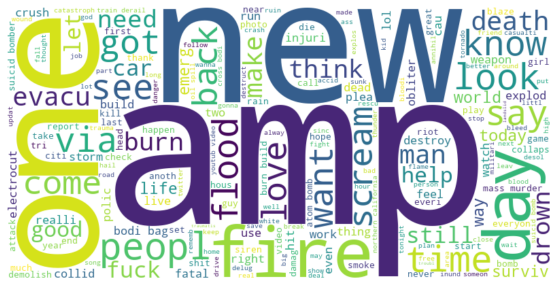

In [13]:
wc = WordCloud(background_color='white', width=800, height=400)
wc.generate(' '.join(train_df['Cleaned_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [14]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

train_df["Cleaned_text"] = train_df["Cleaned_text"].apply(text_cleaning)
test_df["Cleaned_text"] = test_df["Cleaned_text"].apply(text_cleaning)

In [15]:
# Creating function for analysing top n grams

def top_ngrams(data,n,grams):
    '''
    Input:- Data: Input Data
            n   : Number of top n-words
            grams:Type of N-grams. 1-> Unigram  2-> Bigram  3->Trigram
            
    Output: Word Frequency of top  n words
    
    '''
    if grams == 1:
        count_vec = CountVectorizer(ngram_range=(1,1)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 2:
        count_vec = CountVectorizer(ngram_range=(2,2)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 3:
        count_vec = CountVectorizer(ngram_range=(3,3)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)

    return word_freq[:n]

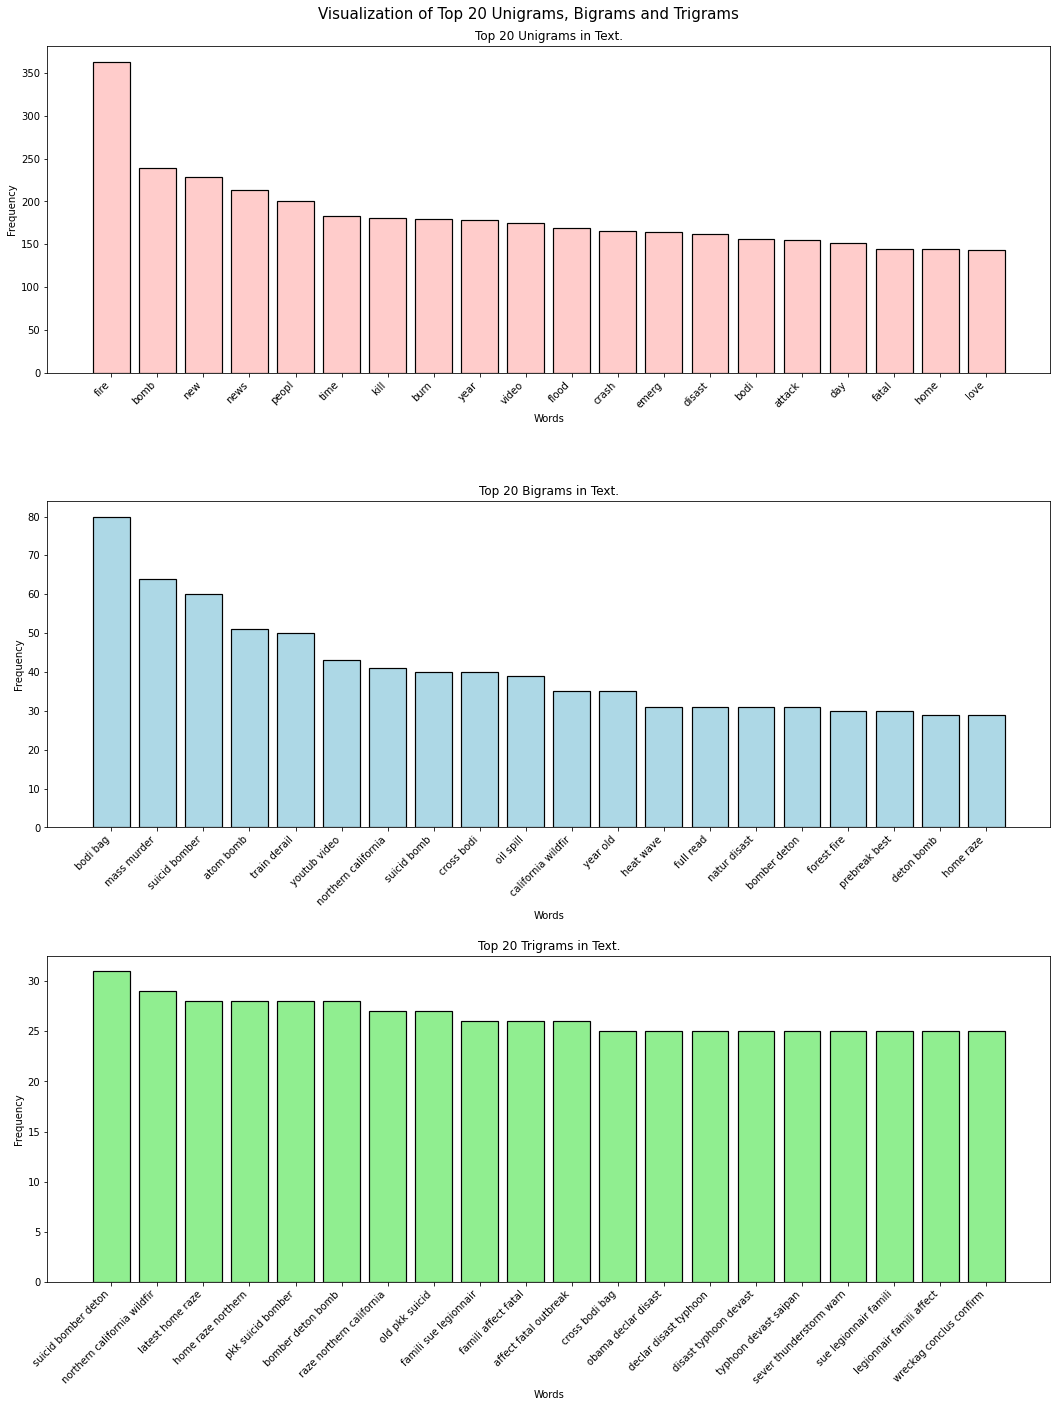

In [16]:
common_words_uni = top_ngrams(train_df["Cleaned_text"],20,1)
common_words_bi = top_ngrams(train_df["Cleaned_text"],20,2)
common_words_tri = top_ngrams(train_df["Cleaned_text"],20,3)
common_words_uni_df = pd.DataFrame(common_words_uni,columns=['word','freq'])
common_words_bi_df = pd.DataFrame(common_words_bi,columns=['word','freq'])
common_words_tri_df = pd.DataFrame(common_words_tri,columns=['word','freq'])
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))
ax1.bar(common_words_uni_df["word"],common_words_uni_df["freq"],color="#FFCCCB",edgecolor='black', linewidth=1.2)
ax1.set_title("Top 20 Unigrams in Text.")
ax1.set_xlabel("Words")
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(rotation=45,ha='right',labels=common_words_uni_df["word"],fontsize=10)    

ax2.bar(common_words_bi_df["word"],common_words_bi_df["freq"],color="lightblue",edgecolor='black', linewidth=1.2)
ax2.set_title("Top 20 Bigrams in Text.")
ax2.set_xlabel("Words")
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(rotation=45,ha='right',labels=common_words_bi_df["word"],fontsize=10)    

ax3.bar(common_words_tri_df["word"],common_words_tri_df["freq"] ,color="lightgreen",edgecolor='black', linewidth=1.2)
ax3.set_title("Top 20 Trigrams in Text.")
ax3.set_xlabel("Words")
ax3.set_ylabel("Frequency")
ax3.set_xticklabels(rotation=45,ha='right',labels=common_words_tri_df["word"],fontsize=10)

plt.suptitle("Visualization of Top 20 Unigrams, Bigrams and Trigrams",fontsize="15")
plt.tight_layout(pad=1.85)
plt.show()

In [17]:
# Creating functions for using BOW,TF-IDF 

def encoding(train_data,test_data,bow,tf_idf):
    '''
    Input : Data to be encoded and choice of encoding.
    Output : Desired Encoding.
    
    '''
    if bow==True: 
        cv = CountVectorizer(ngram_range=(1, 1))
        cv_df_train = cv.fit_transform(train_data).toarray()
        df_train = pd.DataFrame(cv_df_train,columns=cv.get_feature_names())
        cv_df_test = cv.transform(test_data).toarray()
        df_test = pd.DataFrame(cv_df_test,columns=cv.get_feature_names())
        
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(
            ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        df_train = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names())
        tf_df_test = tfidf.transform(test_data).toarray()
        df_test = pd.DataFrame(tf_df_test,columns=tfidf.get_feature_names())
        
    return train_df,test_df


x_final,x_test_final = encoding(train_df["Cleaned_text"],test_df["Cleaned_text"],bow=True,tf_idf=False)
y_final = np.array(y) # Converting y to array

In [18]:
# Checking dimensions of training and testing data
x_final.shape,y_final.shape,x_test_final.shape

((7613, 6), (7613,), (3263, 5))

###### Using Word Embedding using Glove Vectors for Encoding

In [19]:
#Converting to list
text = train_df["Cleaned_text"].tolist()
text_test = test_df["Cleaned_text"].tolist()
text[:3] # Analysing first 3 sentence in train data

['deed reason earthquak allah forgiv',
 'forest fire near rong sask canada',
 'resid ask shelter place notifi offic evacu shelter place order expect']

###### initialize  Tokenizer to read all the words in the text.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(text)

In [21]:
encoded_text = token.texts_to_sequences(text)
encoded_text_test = token.texts_to_sequences(text_test)
encoded_text[:2]

[[3492, 430, 182, 1285, 2785], [110, 1, 153, 5026, 5027, 982]]

In [22]:
#Considering 120 words
max_length = 120 # Considering top 120 tokens.
X = pad_sequences(encoded_text,maxlen=max_length,padding='post') # This is done to make the sequence of same length.
X_test = pad_sequences(encoded_text_test,maxlen=max_length,padding='post')
X

array([[3492,  430,  182, ...,    0,    0,    0],
       [ 110,    1,  153, ...,    0,    0,    0],
       [1286,  481, 1570, ...,    0,    0,    0],
       ...,
       [ 580,  378, 1276, ...,    0,    0,    0],
       [  21,  141, 1877, ...,    0,    0,    0],
       [ 142,   19,  361, ...,    0,    0,    0]])

In [23]:
# Dividing the data into training, validation and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)

###### Logistic Regression

In [24]:
lg = LogisticRegression(C=1.0)
lg.fit(X_train,Y_train)
pred_1 = lg.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.57      0.92      0.71       435
           1       0.45      0.08      0.14       327

    accuracy                           0.56       762
   macro avg       0.51      0.50      0.42       762
weighted avg       0.52      0.56      0.46       762



###### Naive Bayes

In [25]:
nb= MultinomialNB(alpha=0.7)
nb.fit(X_train,Y_train)
pred_2 = nb.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       435
           1       0.48      0.35      0.40       327

    accuracy                           0.56       762
   macro avg       0.54      0.53      0.53       762
weighted avg       0.55      0.56      0.54       762



#### Decision Tree

In [26]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       435
           1       0.59      0.61      0.60       327

    accuracy                           0.65       762
   macro avg       0.64      0.65      0.64       762
weighted avg       0.65      0.65      0.65       762



###### Random Forest

In [27]:
model_4 = RandomForestClassifier(n_estimators = 250 ,max_depth = 15 ,random_state = 42)
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       435
           1       0.66      0.46      0.54       327

    accuracy                           0.67       762
   macro avg       0.66      0.64      0.64       762
weighted avg       0.66      0.67      0.65       762



In [28]:
model_5 = XGBClassifier(learning_rate = 0.01 ,max_depth = 15 ,random_state = 42)
model_5.fit(X_train,Y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       435
           1       0.63      0.50      0.56       327

    accuracy                           0.66       762
   macro avg       0.65      0.64      0.64       762
weighted avg       0.65      0.66      0.65       762



In [29]:
from sklearn.ensemble import VotingClassifier

estimators = []
estimators.append(('LR', 
                  LogisticRegression(C=1.0)))
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('XBG', XGBClassifier()))
estimators.append(('DT',  DecisionTreeClassifier()))

vc = VotingClassifier(estimators=estimators,voting='soft')
vc.fit(X_train,Y_train)
pred_vc = vc.predict(x_test)
cr_vc    = classification_report(y_test,pred_vc)
print(cr_vc)

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       435
           1       0.63      0.59      0.61       327

    accuracy                           0.67       762
   macro avg       0.67      0.66      0.66       762
weighted avg       0.67      0.67      0.67       762



In [30]:
#instantiating random forest regressor
#importing Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()

#using Randomized Search CV for hyper parameter tuning
params = {'n_estimators':[5,10,20,40,80,100,200],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

rcv = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_train,Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 10, 20],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 8, 12],
                                        'n_estimators': [5, 10, 20, 40, 80, 100,
                                                         200],
                                        'oob_score': [True]},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=5)

In [31]:
# best estimator
rcv.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=4, oob_score=True)

In [32]:
# best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 20}

In [33]:
#best score
rcv.best_score_

-0.3377263167475433